In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from utils import extract_time
from utils import random_generator
from utils import MinMaxScaler
from utils import sine_data_generation
from utils import visualization

from modules_and_training import TimeGAN
from modules_and_training import Time_GAN_module

## Real Data Time Series (EEG dataset)



This Notebook generates data for the eeg dataset with
- the original TimeGAN tensorflow code and
- the created pytorch code

In [ ]:
from timegan_orig_tf import *

In [ ]:
import timegan_orig_tf
import pandas as pd
import numpy as np
import torch
import pickle


# Helper Functions

In [ ]:
def real_data_loading (data_name, seq_len):
  """Load and preprocess real-world datasets.
  
  Args:
    - data_name: stock or energy
    - seq_len: sequence length
    
  Returns:
    - data: preprocessed data.
  """  
  assert data_name in ['stock','energy', 'eeg']
  
  if data_name == "eeg":
    ori_data = pd.read_csv("data/eeg.csv")
  else:
    if data_name == 'stock':
      ori_data = np.loadtxt('data/stock_data.csv', delimiter = ",",skiprows = 1)
    elif data_name == 'energy':
      ori_data = np.loadtxt('data/energy_data.csv', delimiter = ",",skiprows = 1)
        
  # Flip the data to make chronological data
  ori_data = ori_data[::-1]
  # Normalize the data
  if data_name != "eeg":
    ori_data = MinMaxScaler(ori_data)
    
  # Preprocess the dataset
  temp_data = []    
  # Cut data by sequence length
  if data_name != "eeg":
    MAX_ROWS = len(ori_data) - seq_len
  else:
    MAX_ROWS = seq_len*500

  for i in range(0, min(len(ori_data) - seq_len, MAX_ROWS)):
    _x = ori_data[i:i + seq_len]
    temp_data.append(_x)
        
  # Mix the datasets (to make it similar to i.i.d)
  idx = np.random.permutation(len(temp_data))    
  data = []
  for i in range(len(temp_data)):
    if (data_name != "eeg"):
       data.append(temp_data[idx[i]])
    else:
       if (temp_data[idx[i]]).isna().sum().sum() == 0: #no NAs
          data.append(temp_data[idx[i]].to_numpy())   
    
  return data

def MinMaxScaler(data):
    """Min-Max Normalizer.
    
    Args:
      - data: raw data
      
    Returns:
      - norm_data: normalized data
      - min_val: minimum values (for renormalization)
      - max_val: maximum values (for renormalization)
    """    
    min_val = np.min(np.min(data, axis = 0), axis = 0)
    data = data - min_val
      
    max_val = np.max(np.max(data, axis = 0), axis = 0)
    norm_data = data / (max_val + 1e-7)
      
    return norm_data, min_val, max_val

## Set network parameters

TimeGAN network parameters should be optimized for different datasets.

- module: gru, lstm, or lstmLN
- hidden_dim: hidden dimensions
- num_layer: number of layers
- iteration: number of training iterations
- batch_size: the number of samples in each batch

In [ ]:
## Network parameters
parameters = dict()

parameters['module'] = 'gru' 
parameters['hidden_dim'] = 20
parameters['num_layer'] = 3
parameters['iterations'] = 10000
parameters['batch_size'] = 128

In [ ]:
#input_size = 5 # sequence length = number of features
data_name = "eeg"
output_size = 20
hidden_dim = 40
n_layers = 1
gamma = 1

no, seq_len, dim = 12800, 24, 1

batch_size = 128
epoch = 100

In [ ]:
if data_name == "eeg":
  data = real_data_loading(data_name, seq_len) #file too big for github
  dim = 7
else:
  data = sine_data_generation(no, seq_len, dim)


### 1. generate "fake" eeg-like data with original tensorflow code




In [ ]:
# Run TimeGAN
#%tensorflow_version 1.x
generated_data = timegan(ori_data, parameters)   
print('Finish Synthetic Data Generation')

max seq len: 24
Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensor

In [ ]:
pickle.dump( generated_data, open( "generated_data_rve_eeg.pickle", "wb" ) )

## Evaluate the generated data

### 1. Discriminative score

To evaluate the classification accuracy between original and synthetic data using post-hoc RNN network. The output is |classification accuracy - 0.5|.

- metric_iteration: the number of iterations for metric computation.

In [ ]:
metric_iteration = 5

discriminative_score = list()
for _ in range(metric_iteration):
  temp_disc = discriminative_score_metrics(ori_data, generated_data)
  discriminative_score.append(temp_disc)

print('Discriminative score: ' + str(np.round(np.mean(discriminative_score), 4)))


Instructions for updating:
Please use tf.global_variables instead.
Discriminative score: 0.1783


## Evaluate the generated data

### 2. Predictive score

To evaluate the prediction performance on train on synthetic, test on real setting. More specifically, we use Post-hoc RNN architecture to predict one-step ahead and report the performance in terms of MAE.

In [ ]:
predictive_score = list()
for tt in range(metric_iteration):
  temp_pred = predictive_score_metrics(ori_data, generated_data)
  predictive_score.append(temp_pred)   
    
print('Predictive score: ' + str(np.round(np.mean(predictive_score), 4)))


Predictive score: 18.5197


## Evaluate the generated data

### 3. Visualization

We visualize the original and synthetic data distributions using PCA and tSNE analysis.

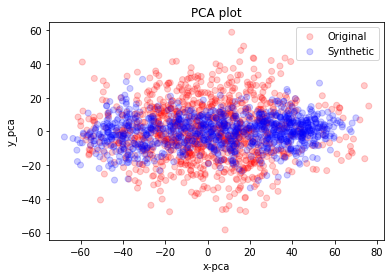

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.005s...
[t-SNE] Computed neighbors for 2000 samples in 0.293s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 13.225275
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.221405
[t-SNE] KL divergence after 300 iterations: 2.117206


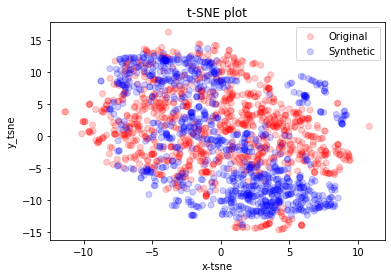

In [ ]:
visualization(ori_data, generated_data, 'pca')
visualization(ori_data, generated_data, 'tsne')

### 2. generate "fake" eeg-like data with newly created pytorch code


In [ ]:
seq_len, dim = 24, 7

parameters = dict()
parameters['module'] = 'gru' 
parameters['hidden_dim'] = 40
parameters['num_layers'] = 1
parameters['iterations'] = 100
parameters['batch_size'] = 553#
parameters['epoch'] = 2

data = torch.Tensor(data)


Start Embedding Network Training
step: 1/2, e_loss: 17.026407
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 1/2, s_loss: 0.16722645
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/2, D_loss: 3.9022648, G_loss_U: 0.22096132, G_loss_S: 0.028199883, E_loss_t0: 17.015446


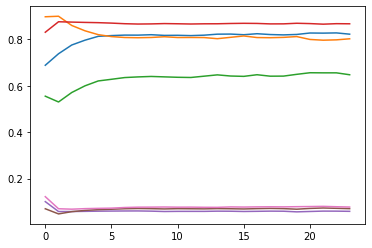

step: 0/2, D_loss: 3.3200996, G_loss_U: 0.32817334, G_loss_S: 0.028585697, E_loss_t0: 16.986084


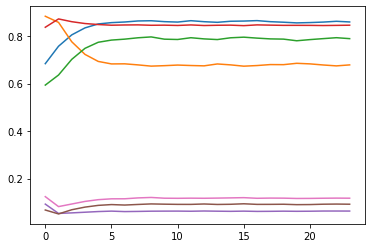

step: 0/2, D_loss: 2.6968398, G_loss_U: 0.47494116, G_loss_S: 0.02973614, E_loss_t0: 16.940548


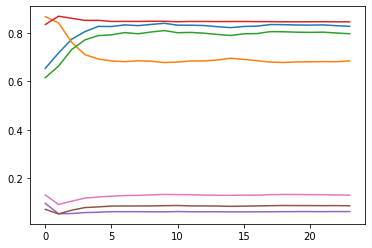

step: 0/2, D_loss: 2.2736912, G_loss_U: 0.64034593, G_loss_S: 0.031199308, E_loss_t0: 16.87038


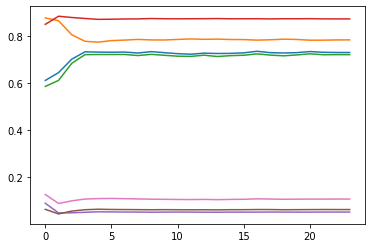

step: 1/2, D_loss: 1.9631473, G_loss_U: 0.8288132, G_loss_S: 0.036905408, E_loss_t0: 17.00172


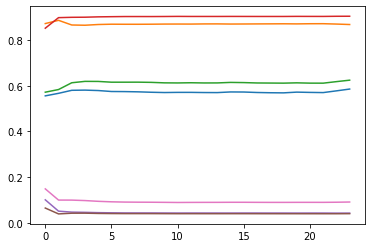

step: 1/2, D_loss: 1.9441978, G_loss_U: 0.8611117, G_loss_S: 0.03860827, E_loss_t0: 16.971617


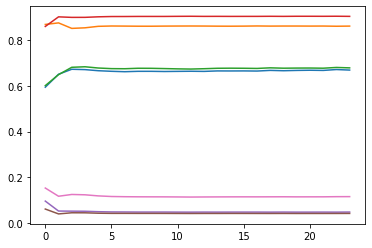

step: 1/2, D_loss: 1.9221145, G_loss_U: 0.8905837, G_loss_S: 0.040836986, E_loss_t0: 16.925638


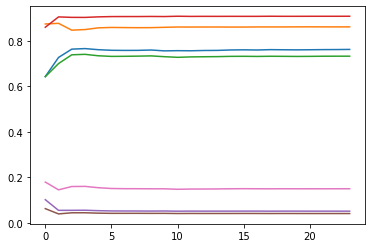

step: 1/2, D_loss: 1.898456, G_loss_U: 0.9185088, G_loss_S: 0.04302913, E_loss_t0: 16.85637


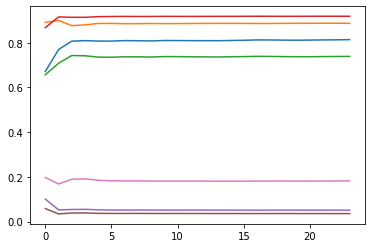

Finish Joint Training


In [ ]:
Generator, Embedder, Supervisor, Recovery, Discriminator, checkpoints = TimeGAN(data, parameters)

In [ ]:
no = 2212

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.007s...
[t-SNE] Computed neighbors for 2000 samples in 0.252s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.000745
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.044662
[t-SNE] KL divergence after 300 iterations: 1.610959


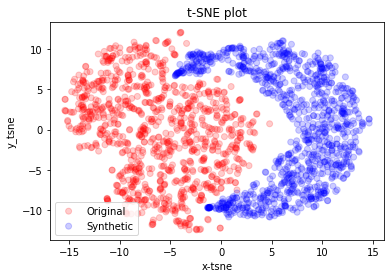

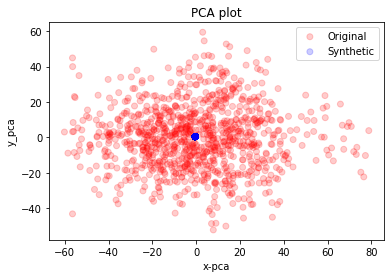

In [ ]:
random_test = random_generator(no, dim, extract_time(data)[0], extract_time(data)[1])
test_sample = Generator(torch.tensor(random_generator(no, dim, extract_time(data)[0], extract_time(data)[1])).float())[0]
test_sample = torch.reshape(test_sample, (no, seq_len, parameters['hidden_dim']))
test_recovery = Recovery(test_sample)
test_recovery = torch.reshape(test_recovery[0], (no, seq_len, dim))
visualization(data, test_recovery.detach().numpy(), 'tsne')
visualization(data, test_recovery.detach().numpy(), 'pca')
  